## 📜 Baybayin Character Classification

`Name: Christian Jay Baguio`

`Date: September 30, 2024`

**Instructions**

In this activity, your goal is to complete and refine the provided code to develop an image classification model for Baybayin handwritten characters. Additionally, ensure that you answer the accompanying questions in a **clear and concise** manner.

- You are allowed to open the notebooks provided, but you are not allowed to access the internet or any external sources.
- Collaboration with classmates is not permitted. All work must be completed independently.
- You may only use the tools and libraries that are specified within the provided environment.

**Context**

Baybayin is a pre-colonial script used primarily by the Tagalog people of the Philippines. It is one of the many indigenous scripts found in the Philippines and is also known as "Alibata," although this term is now considered a misnomer.

The Baybayin script is an ancient writing system, which is believed to have originated from the Brahmic scripts of India. It consists of 17 basic characters representing syllables. Each character represents a consonant with an inherent vowel sound "a." To change the vowel sound, diacritical marks are added above, below, or beside the character.

Baybayin was primarily used for inscriptions on various materials like bamboo, palm leaves, and bark. It was used to record important information such as laws, religious texts, poetry, and genealogies.

With the arrival of Spanish colonialists in the Philippines during the 16th century, Baybayin gradually declined in use as the Latin script was introduced and imposed as the official writing system. As a result, Baybayin was eventually marginalized and almost forgotten, particularly in more urbanized areas.

In recent years, there has been a resurgence of interest in Baybayin as part of the cultural heritage of the Philippines. Efforts are being made to revive and preserve the script, with some schools and cultural organizations promoting its use and teaching it to the younger generations. Additionally, you may find Baybayin being used in modern art, design, and tattoos as a way to celebrate and reconnect with the country's pre-colonial roots.

**📦Libraries**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
import time

In [2]:
root_dir = 'baybayin2'

**🎯 Create a Dataset**

In [3]:
class BaybayinDataset(Dataset):
    def __init__(self, root_dir, image_trans=None, class_mapping=True):
        self.image_trans = image_trans
        self.img_paths = sorted([os.path.join(root_dir, i)for i in os.listdir(root_dir) if i.endswith('.jpg')])
        self.labels = [i.split('\\')[-1].split('.')[0] for i in self.img_paths]
        self.class_map = {}
        if class_mapping:
            self.class_map = {label:idx for idx, label in enumerate(set(self.labels))}
 
    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.img_paths[idx]), cv2.COLOR_BGR2RGB)
        label = self.class_map[self.labels[idx]] if len(self.class_map) > 0 else self.labels[idx]
        if self.image_trans:
            image = self.image_trans(image)
            try:
                label = torch.tensor(label)
            except TypeError as te:
                raise Exception('Set the class_mapping to True')
 
        return image, label
 
    def __len__(self):
        return len(self.img_paths)

**🎯 Dataset Object**

> Instantiate a dataset object, the image transformation method should be a simple ToTensor().

In [5]:
transform = T.Compose([
    T.ToTensor(), T.Resize(size=(250, 250))
])

dataset = BaybayinDataset(root_dir, transform)

**🎯 Visualize each Class**

 ![image.png](attachment:1f2fbb69-a156-4274-b062-8869a1221536.png)
 
> You might want to use the `permute(1,2,0)` function for tensor images.

In [10]:
samp = {}

for idx, i in enumerate(dataset.img_paths):
    lbl = i.split('\\')[1]
    samp[lbl] = idx

In [35]:
samp

{'a.0JWo-James.jpg': 0,
 'a.0xvU-Lutian Grace .jpg': 1,
 'a.11PX-James.jpg': 2,
 'a.1CQN-James.jpg': 3,
 'a.1Jjh-Lutian Grace .jpg': 4,
 'a.2aoN-James.jpg': 5,
 'a.2cqF-Luntian Grace.jpg': 6,
 'a.30tp-James.jpg': 7,
 'a.3586-James.jpg': 8,
 'a.3AKv-Niall.jpg': 9,
 'a.3qrn-James.jpg': 10,
 'a.4H3k-James.jpg': 11,
 'a.4MZN-Louis.jpg': 12,
 'a.4pMw-James.jpg': 13,
 'a.5mRk-Roger.jpg': 14,
 'a.6HJr-James.jpg': 15,
 'a.6PUH-James.jpg': 16,
 'a.6b02-James.jpg': 17,
 'a.6v7K-James.jpg': 18,
 'a.74ID-James.jpg': 19,
 'a.7rwN-James.jpg': 20,
 'a.840N-Luntian Grace.jpg': 21,
 'a.9Frs-James.jpg': 22,
 'a.9Hep-James.jpg': 23,
 'a.9Z4b-James.jpg': 24,
 'a.A5Bb-James.jpg': 25,
 'a.A818-James.jpg': 26,
 'a.AXgu-James.jpg': 27,
 'a.AdGd-James.jpg': 28,
 'a.Aq2G-James.jpg': 29,
 'a.BFxk-James.jpg': 30,
 'a.BT06-James.jpg': 31,
 'a.BcYj-James.jpg': 32,
 'a.Bk90-James.jpg': 33,
 'a.CEmJ-James.jpg': 34,
 'a.CIU3-James.jpg': 35,
 'a.DEjE-James.jpg': 36,
 'a.Dj99-James.jpg': 37,
 'a.EoDh-James.jpg': 38,
 'a

In [14]:
for i,j in samp.items():
    plt.imshow(dataset[j][0].permute(1,2,0))
    plt.title(i)
    plt.axis('off')
    plt.show()

AttributeError: 'dict' object has no attribute 'head'

**🎯 Partition dataset and create `DataLoader` objects.**

<div class="alert alert-block alert-info"><b>Question 1: </b> What is the purpose of a <b><tt>DataLoader</tt></b>? </br>
<b><tt>Answer: </tt></b> The primary use of Dataloader is it allows the user to wrap an iterable inside the dataset to enable easy access to its samples.
</div> 

In [36]:
train_set, test_set, val_set = random_split(dataset, [0.7, 0.1, 0.2])

batch_size=16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [37]:
xb, yb = next(iter(train_loader))
xb

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1

In [38]:
display(xb.shape)
display(yb.shape)

torch.Size([16, 3, 250, 250])

torch.Size([16])

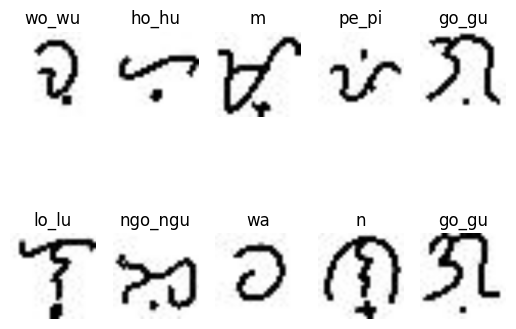

In [39]:
map = {v:k for k,v in dataset.class_map.items()}
fig, axs = plt.subplots(nrows=2, ncols=5)

c = 0
for row in range(2):
    for col in range(5):
        axs[row, col].imshow(xb[c].permute(1,2,0))
        axs[row, col].axis('off')
        axs[row, col].set_title(map[yb[c].item()])
        c += 1
plt.show()

**🎯 Make Model**

<div class="alert alert-block alert-info"><b>Question 2: </b> What is the importance of adding a ReLU in every convolution?</br>
<b><tt>Answer: </tt></b> ReLU or Rectified Linear Unit is a type of activation function that introduces linearity of the model.

</div> 

<center><img src= '28x28_Arch.png' width="400px"></center>

In [40]:
def calc_out(w, f, s, p):
    """
    Calculate output shape of a matrix after a convolution.
    The results are only applicable for square matrix kernels and images only.
    """
    print(f'Output Shape: {(w - f + 2 * p) // s + 1}')

In [54]:
set_seed(143)
images, labels = xb, yb

def display_image(batch):
    batch = batch.detach().numpy()
    fig, axs = plt.subplots(1, len(batch), figsize=(12, 2))
    for i in range(len(batch)):
        axs[i].imshow(batch[i, 0, :, :], vmin=0, vmax=1)
        axs[i].axis('off')
        axs[i].set_title(labels[i].numpy())
    plt.show()

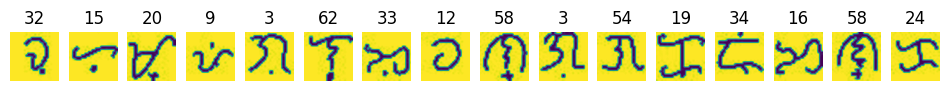

torch.Size([16, 3, 250, 250])


In [55]:
display_image(images)
print(images.shape)

# (b, c, h, w)

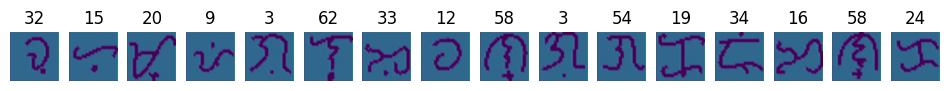

torch.Size([16, 32, 250, 250])


In [56]:
conv1 = nn.Conv2d(3, 32, (3,3), 1, 1)

x = F.relu(conv1(images))
display_image(x)
print(x.shape)

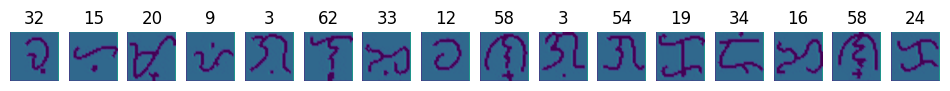

torch.Size([16, 32, 126, 126])


In [57]:
pool1 = nn.MaxPool2d((2,2), 2, 1)

x = pool1(x)
display_image(x)
print(x.shape)

In [58]:
conv2 = nn.Conv2d(32, 64, (3,3), 1, 1)
x = F.relu(conv2(x))
conv3 = nn.Conv2d(64, 128, (3,3), 1, 1)
x = F.relu(conv3(x))
conv4 = nn.Conv2d(128, 256, (3,3), 1, 1)
x = F.relu(conv4(x))

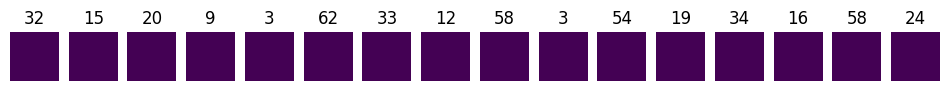

torch.Size([16, 256, 63, 63])


In [59]:
pool2 = nn.MaxPool2d((2,2), 2, 0)

x = pool2(x)
display_image(x)
print(x.shape)

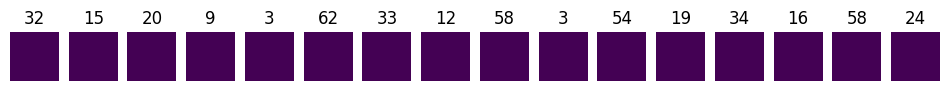

torch.Size([16, 256, 63, 63])


In [60]:
dropout = nn.Dropout(0.2)

x = dropout(x)
display_image(x)
print(x.shape)

In [71]:
class CNNModel(nn.Module):
    def __init__(self, in_channels, out_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, (3,3), 1, 1)
        self.pool1 = nn.MaxPool2d((2,2), 2, 1)
        
        self.conv2 = nn.Conv2d(32, 64, (3,3), 1, 1)
        self.conv3 = nn.Conv2d(64, 128, (3,3), 1, 1)
        self.conv4 = nn.Conv2d(128, 256, (3,3), 1, 1)
        self.pool2 = nn.MaxPool2d((2,2), 2)
        
        self.dropout = nn.Dropout(0.2)
        self.fcn1 = nn.Linear(256*63*63, 1000)
        self.fcn2 = nn.Linear(1000, 500)
        self.fcn3 = nn.Linear(500, out_dim)
        pass

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        x = self.dropout(x)
        x = x.view(-1, 256*63*63)
        x = F.relu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        x = self.fcn3(x)
        pass

In [72]:
model = CNNModel(3, 16)
model

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 4064256000 bytes.

**🎯 Training Loop**

- Use `nn.CrossEntropyLoss` as the criterion and;
- `torch.optim.Adam` for the optimizer.


<div class="alert alert-block alert-info"><b>Question 3: </b> Explain the purpose of a loss function.</br>
<b>To quantifies the difference between the predicted outputs and the actual target values.
</div> 

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = model.to(device)

In [69]:
epochs = 20
for e in range(epochs):

    model.train()
    for train_batch in train_loader:
        x_train = train_batch[0].to(device)
        y_train = train_batch[1].to(device)

        optimizer.zero_grad()
        
        train_pred = model(x_train)
        train_loss = loss_fn(torch.argmax(train_pred, dim=1).to(torch.float32), y_train.to(torch.float32))

        train_loss.backward()
        optimizer.step()

    print(train_loss)

    model.eval()
    for val_batch in val_loader:
        x_val = val_batch[0].to(device)
        y_val = val_batch[1].to(device)
        with torch.no_grad():
            val_pred = model(x_val)

        print(torch.argmax(val_pred, dim=1))
        print(y_val)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5184x3136 and 1016064x1000)

<div class="alert alert-block alert-info"><b>Question 4: </b> Why is it necessary to backpropagate?</br>
<b>To train a Neural Nets to make better predictions through supervised learning.</b>
</div> 

<div class="alert alert-block alert-info"><b>Question 5: </b> What is your observation from this model? and how can it be improved?</div> 